In [128]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Input, concatenate
from keras.callbacks import TensorBoard 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter


In [129]:
corpus=[] #Crea lista corpus que contiene 
target=[] #Crea lista target que contiene 
edad=[] #Crea lista edad que contiene 
sexo=[] #Crea lista sexo que contiene 
severidad=[] #Crea lista severidad que contiene 

archivo=open("dataset_elpino.csv",encoding="utf-8")
header=archivo.readline().strip().split(";")
features=[] #Crea lista features que contiene 
for col in header: #recorre la cantidad de columnas en el csv
    col=col.split("-")[0].strip() 
    if col.startswith("Diag") or col.startswith("Proc"): #separa los diag de los proc.
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col) #Añade todas los headers de las columnas (diagnosticos, procedimientos)
for linea in archivo: 
    row=[] #crea una lista para almacenar la fila actual
    linea=linea.strip().split(";") #separa la lista por ;
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67: # Si el índice "i" es 67 (columna 68).
            grd=col
            #target.append(grd[-1])
            target.append(grd) #almacena el grd de la fila actual
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0) # almacena el sexo 1 si es mujer 0 si es hombre
        elif i==65:
            edad.append(int(col))#se alamacena la edad
        else:
            row.append(col) #se guardan el codigo de la columna correspondientes a la fila
    corpus.append(row)

In [130]:
df=pd.DataFrame(corpus,columns=features[:-3])  #crea una tabla de datos (un DataFrame) a partir de la información que le damos. ingresamos corpus (matris con los codigos de los diagnosticos ) y fetures (como queremos dividir las columnas)
df["GRD"]=target #Esto crea una nueva columna en el DataFrame df y la nombra "GRD".
df

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,99.21,99.29,90.52,91.39,91.32,93.90,99.15,96.59,45.13,041023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14556,E10.1,J45.9,F10.2,F17.2,Z91.1,,,,,,...,,,,,,,,,,104101
14557,S09.9,W18.24,R55,,,,,,,,...,,,,,,,,,,014242
14558,K92.1,I10,E11.9,I50.9,K25.9,M16.9,G47.3,Z99.8,,,...,,,,,,,,,,064182
14559,E78.1,I10,Z92.2,,,,,,,,...,,,,,,,,,,104121


In [131]:
dfsexo = pd.DataFrame({"Sexo": sexo, "GRD": target})

In [132]:
filtro=(df["GRD"]=='041021') | (df["GRD"]=='041022') | (df["GRD"]=='041023') #Crea un filtro en el cual se crea un data set solo con los codigos ingresados

In [133]:
data=df[filtro] #crea una data especialmete con el filtro

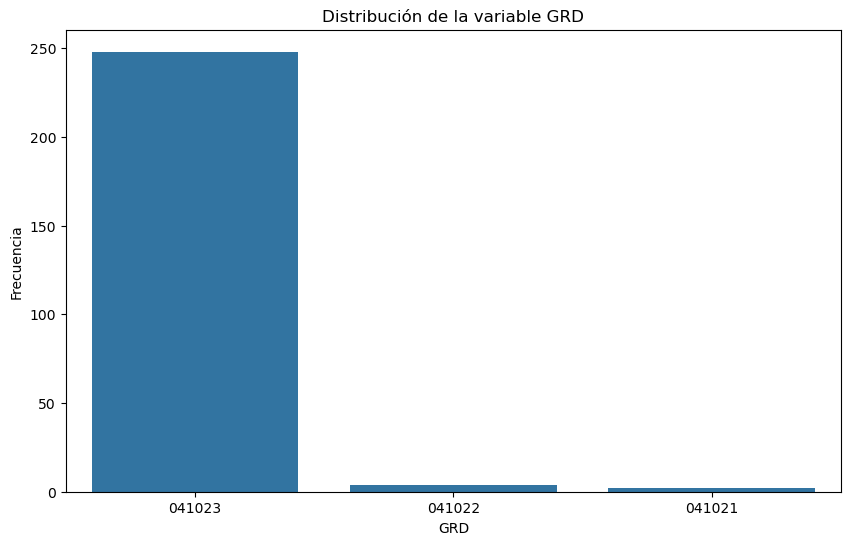

In [134]:
plt.figure(figsize=(10, 6))
sns.countplot(x='GRD', data=data)
plt.title('Distribución de la variable GRD')
plt.xlabel('GRD')
plt.ylabel('Frecuencia')
plt.show()
print("\n" + "="*50 + "\n")

In [135]:
datasexo=dfsexo[filtro] #crea una data especialmete con el filtro


In [136]:
cantidad_ceros = (datasexo["Sexo"] == 0).sum()
if cantidad_ceros > 0:
    print(f"Hay {cantidad_ceros} ceros en la columna 'Sexo'")
else:
    print("No hay ningún 0 (Homre) en la columna 'Sexo'")

Hay 150 ceros en la columna 'Sexo'


In [137]:
features_procedimientos=[] #crea una lista de procediminetos
features_diagnosticos=[] #crea una lista de diagnosticos
for j in range(1,36):  #recorre las columnas relacionadas al diagnostico del grd
    field="Diag"+str(j).zfill(2) #rellena el texto con el numero de la columna, ---.zfill(2) rellena la cadena de texto con ceros a la izquierda hasta que tenga una longitud de 2 caracteres. Por ejemplo, si j es 1, str(j) será "1", y .zfill(2) lo convertirá en "01". Si j es 10, str(j) será "10", y .zfill(2) lo dejará como "10".
    features_diagnosticos.append(field) #Esto agrega el valor de field a la lista features_diagnosticos.
for j in range(1,31): #recorre las columnas relacionadas al procedimiento del grd
    field="Proced"+str(j).zfill(2)#.rellena el texto con el numero de la columna
    features_procedimientos.append(field)#Esto agrega el valor de field a la lista features_procedimientos.


In [138]:
procedimientos={}#Esto crea un diccionario vacío llamado procedimientos. Este diccionario se utilizará para contar la frecuencia de cada código de procedimiento.
diagnosticos={}#Esto crea un diccionario vacío llamado diagnosticos. Este diccionario se utilizará para contar la frecuencia de cada código de diagnosticos.
for i, row in data.iterrows():#Esto inicia un bucle for que itera sobre cada fila del  data
    for j in range(1,36): #recorre las columas dianostico
        field="Diag"+str(j).zfill(2) #rellena el texto con el numero de la columna
        if row[field] not in diagnosticos:#esto verifica si el valor de la celda actual (el código de diagnóstico) ya existe como clave en el diccionario diagnosticos.
            diagnosticos[row[field]]=1 #Si el código de diagnóstico no existe en el diccionario, se agrega como clave con un valor de 1
        else:
            diagnosticos[row[field]]+=1#suma uno al contador de diagnosticos
    for j in range(1,31):#recorre las columas procedimientos
        field="Proced"+str(j).zfill(2) #rellena el texto con el numero de la columna
        if row[field] not in procedimientos:#esto verifica si el valor de la celda actual (el código de procedimientos) ya existe como clave en el diccionario procedimientos.
            procedimientos[row[field]]=1#Si el código de procedimientos no existe en el diccionario, se agrega como clave con un valor de 1
        else:
            procedimientos[row[field]]+=1#suma uno al contador de procedimientos
token_diagnosticos=list(diagnosticos.keys())#Esto crea una lista llamada token_diagnosticos que contiene todos los códigos de diagnóstico únicos encontrados en el DataFrame.
token_procedimientos=list(procedimientos.keys())#Esto crea una lista llamada token_procedimientos que contiene todos los códigos de procedimientos únicos encontrados en el DataFrame.
vocabulario=len(token_diagnosticos)+len(token_procedimientos)+1#Esto calcula el tamaño del vocabulario total, que es la suma del número de diagnósticos únicos, el número de procedimientos únicos
print("Diagnósticos: ",len(token_diagnosticos))
print("Procedimientos: ",len(token_procedimientos))
print("Vocabulario: ",vocabulario)

Diagnósticos:  854
Procedimientos:  297
Vocabulario:  1152


In [139]:
token_rows=[]#Esto crea una lista vacía llamada token_rows
for i, row in data.iterrows():
    token_row=[]#Crea una lista vacía llamada token_row para almacenar los tokens numéricos de la fila actual.
    for j in range(1,36):#bucle entre las columnas de diagnostico
        field="Diag"+str(j).zfill(2)#rellena el texto con el numero de la columna
        token_row.append(1+token_diagnosticos.index(row[field])) #obtiene el código de diagnóstico de la celda actual, encuentra el índice del código de diagnóstico en la lista token_diagnosticos, suma 1 al índice encontrado. Esto asegura que los tokens de diagnóstico comiencen desde 1 en lugar de 0.agrega el token numérico a la lista token_row
    for j in range(1,31):#bucle entre las columnas de procedimientos
        field="Proced"+str(j).zfill(2)#rellena el texto con el numero de la columna
        token_row.append(1+len(token_diagnosticos)+token_procedimientos.index(row[field]))#obtiene el código de procedimientos de la celda actual, encuentra el índice del código de procedimientos en la lista token_diagnosticos,suma 1 y 377 al índice encontrado. El número 377 parece ser el total de codigos de diagnosticos unicos encontrados anteriormente. Esto se hace para que los tokens de procedimiento tengan valores distintos a los tokens de diagnóstico.
    token_rows.append(token_row)#Después de procesar todas las columnas de diagnóstico y procedimiento de una fila, esto agrega la lista token_row

len(token_diagnosticos) 

854

Codigo 1 Red Neuronal

In [140]:

# Asumiendo que 'data' es tu DataFrame filtrado y 'token_rows' es tu lista de tokens numéricos

# Crear secuencias con diagnósticos y procedimientos
secuencias_tokens = [row[:65] for row in token_rows]  # Tomar los primeros 65 tokens (diagnósticos y procedimientos)

# Rellenar las secuencias para que tengan la misma longitud
max_longitud = max(len(seq) for seq in secuencias_tokens)
secuencias_padded = pad_sequences(secuencias_tokens, maxlen=max_longitud)

# Codificar la variable objetivo 'GRD' a numérico
le_grd = LabelEncoder()
target_encoded = le_grd.fit_transform(data['GRD'])
num_classes = len(np.unique(target_encoded))  # Asegurar el número correcto de clases


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias_padded, target_encoded, test_size=0.3, random_state=42)
vocabulario_size = len(set(token for row in secuencias_tokens for token in row)) + 1  # +1 para el relleno
vocabulario_size
print(f"Tamaño del vocabulario calculado: {vocabulario_size}")
print(f"Longitud máxima de la secuencia: {max_longitud}")

Tamaño del vocabulario calculado: 1152
Longitud máxima de la secuencia: 65


In [141]:

model = Sequential()
model.add(Embedding(vocabulario_size, 100, input_length=max_longitud))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax')) # 3 neuronas para las 3 clases

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Usar sparse_categorical_crossentropy

# Configuración de TensorBoard
log_dir = "logs/fit/diagproc/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenar el modelo con TensorBoard
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Imprimir información adicional
print("Valores únicos en y_train:", np.unique(y_train))
print("Valores únicos en y_test:", np.unique(y_test))

Epoch 1/10
5/5 [==============================] - 1s 111ms/step - loss: 0.5918 - accuracy: 0.9574 - val_loss: 0.1870 - val_accuracy: 0.9722
Epoch 2/10
5/5 [==============================] - 0s 87ms/step - loss: 0.1309 - accuracy: 0.9787 - val_loss: 0.2314 - val_accuracy: 0.9722
Epoch 3/10
5/5 [==============================] - 0s 101ms/step - loss: 0.1367 - accuracy: 0.9787 - val_loss: 0.2544 - val_accuracy: 0.9722
Epoch 4/10
5/5 [==============================] - 0s 84ms/step - loss: 0.1032 - accuracy: 0.9787 - val_loss: 0.2073 - val_accuracy: 0.9722
Epoch 5/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0344 - accuracy: 0.9787 - val_loss: 0.1650 - val_accuracy: 0.9722
Epoch 6/10
5/5 [==============================] - 0s 75ms/step - loss: 0.0162 - accuracy: 0.9929 - val_loss: 0.1391 - val_accuracy: 0.9722
Epoch 7/10
5/5 [==============================] - 0s 80ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.1310 - val_accuracy: 0.9722
Epoch 8/10
5/5 [=========

3/3 [==============================] - 0s 5ms/step


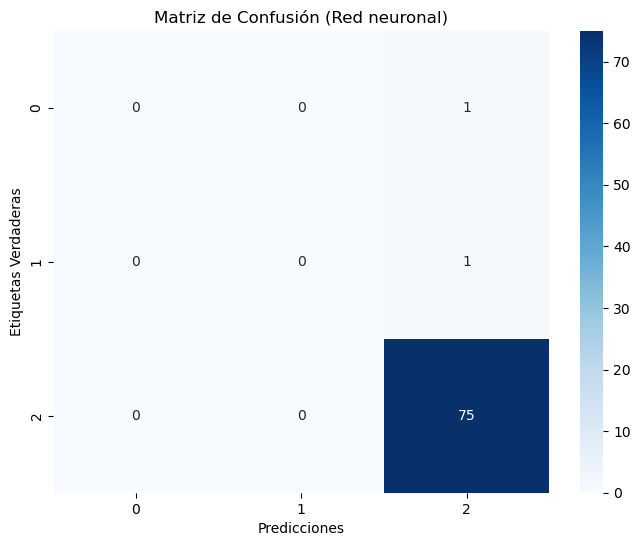

Número total de pruebas realizadas: 77
Número total de filas analizadas: 254


In [ ]:
# Obtener las predicciones del modelo
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calcular la matriz de confusión usando y_test y y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión (Red neuronal)')
plt.show()

# Imprimir el número total de pruebas realizadas
total_pruebas = np.sum(cm)
print(f"Número total de pruebas realizadas: {total_pruebas}")

#imprimir el numero total de filas analizadas, si la variable data existe.
try:  
  print(f"Número total de filas analizadas: {len(data)}")
except NameError:
  print("La variable 'data' no está definida.")

Matriz de Confusión Binaria para la Clase 0:


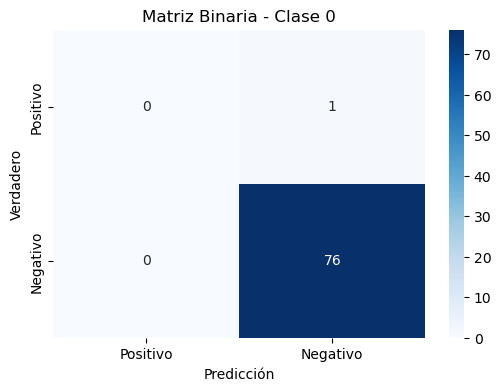

Métricas para la Clase 0:
  Precisión: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
------------------------------
Matriz de Confusión Binaria para la Clase 1:


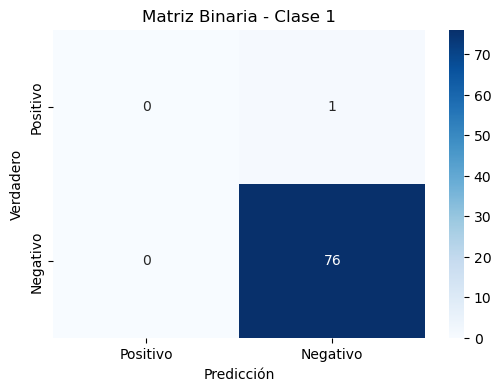

Métricas para la Clase 1:
  Precisión: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
------------------------------
Matriz de Confusión Binaria para la Clase 2:


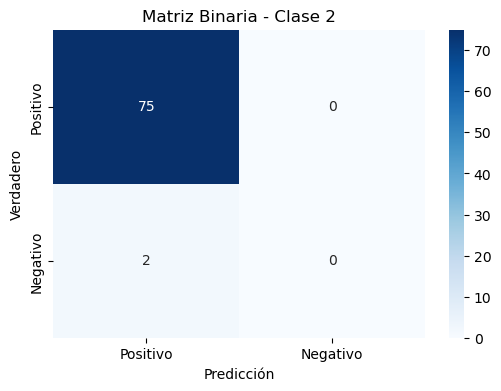

Métricas para la Clase 2:
  Precisión: 0.9740
  Recall: 1.0000
  F1-score: 0.9868
------------------------------


In [143]:
num_clases = cm.shape[0]

for i in range(num_clases):
    # Crear matriz binaria para la clase i
    cm_binario = np.zeros((2, 2), dtype=int)
    cm_binario[0, 0] = cm[i, i]  # Verdaderos Positivos
    cm_binario[0, 1] = np.sum(cm[i, :]) - cm[i, i]  # Falsos Negativos
    cm_binario[1, 0] = np.sum(cm[:, i]) - cm[i, i]  # Falsos Positivos
    cm_binario[1, 1] = np.sum(cm) - cm[i, :].sum() - cm[:, i].sum() + cm[i, i] # Verdaderos Negativos

    print(f"Matriz de Confusión Binaria para la Clase {i}:")

    # Visualizar la matriz de confusión binaria
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_binario, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz Binaria - Clase {i}')
    plt.show()

    # Calcular precisión, recall y F1-score para la clase i
    tp = cm_binario[0, 0]
    fp = cm_binario[1, 0]
    fn = cm_binario[0, 1]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Métricas para la Clase {i}:")
    print(f"  Precisión: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("-" * 30)